In [31]:
#basic imports and ipython setup
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('paperstyle.mpl')
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm
from MCEq.geometry.geometry import EarthGeometry

In [2]:
class Units(object):
    # units
    Na = 6.0221415e+23 # mol/cm^3
    km = 5.0677309374099995 # km to GeV^-1 value from SQuIDS
    cm = km*1.e-5
    m = km*1.e-3
    gr = 5.62e23 # gr to GeV value from SQuIDS
    sec = 1523000.0 #$ sec to GeV^-1 from SQuIDS
    day = sec*60**2*24
    yr = day*356.25
    GeV = 1
    MeV = 1e-3*GeV
    TeV = 1.e3*GeV
    PeV = 1.e3*TeV
    mol_air = config.A_target
    phim2 = (m**2*GeV*sec)**-1
    phicm2 = (cm**2*GeV*sec)**-1

class Geometry(EarthGeometry):
    def __init__(self, depth):
        """ Depth of detector and elevation of surface above sea-level
        """
        super(Geometry, self).__init__()
        self.depth = depth
        self.h_obs *= Units.cm
        self.h_atm *= Units.cm
        self.r_E *= Units.cm
        self.r_top = self.r_E + self.h_atm
        self.r_obs = self.r_E + self.h_obs


    def overburden(self, cos_theta):
        """Returns the overburden for a detector at *depth* below some surface
        at *elevation*.
        From law of cosines,
        x^2 == r^2+(r-d)^2-2r(r-d)cos(gamma)
        where
        r*cos(gamma) = r-d+x*cos(theta), solve and return x.
        :param cos_theta: cosine of zenith angle in detector coord
        """
        d = self.depth
        r = self.r_E
        z = r-d
        return (np.sqrt(z**2*cos_theta**2+d*(2*r-d))-z*cos_theta)/Units.m


    def overburden_to_cos_theta(self, l):
        """Returns the theta for a given overburden for a detector at 
        *depth* below some surface at *elevation*.
        From law of cosines,
        x^2 == r^2+(r-d)^2-2r(r-d)cos(gamma)
        where
        r*cos(gamma) = r-d+x*cos(theta), solve and return x.
        :param cos_theta: cosine of zenith angle in detector coord
        """
        d = self.depth
        r = self.r_E
        z = r-d
        return (2*d*r-d**2-l**2)/(2*l*z)


    def cos_theta_eff(self, cos_theta):
        """ Returns the effective cos_theta relative the the normal at earth surface.
        :param cos_theta: cosine of zenith angle (detector)
        """
        d = self.depth
        r = self.r_E
        z = r-d
        return np.sqrt(1-(z/r)**2*(1-cos_theta**2))

In [16]:
cos_theta_grid = np.linspace(-1,1,100+1)
print(cos_theta_grid)

[-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66
  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9
  0.92  0.94  0.96  0.98  1.  ]


In [18]:
mceq_run = MCEqRun(
        'SIBYLL-2.3c',
        primary_model=(pm.HillasGaisser2012, 'H3a'),
        theta_deg=0.0,
        density_model=('CORSIKA', ('SouthPole', 'December')),
    )
mag = 0
geometry = Geometry(1950.*Units.m)
flux = {}
for frac in ['mu_conv','mu_pr','mu_total','mu_pi','mu_k',
             'numu_conv','numu_pr','numu_total','numu_pi','numu_k',
             'nue_conv','nue_pr','nue_total', 'nue_pi','nue_k',
             'nutau_pr']:
    flux[frac] = []
for cos_theta in cos_theta_grid:
    cos_theta_eff = geometry.cos_theta_eff(cos_theta)
    mceq_run.set_theta_deg(np.arccos(cos_theta_eff)*180./np.pi)*np.sign(cos_theta)
    mceq_run.solve()
    flux['mu_conv'].append(mceq_run.get_solution('conv_mu+', mag)
                           + mceq_run.get_solution('conv_mu-', mag))

    # _pr means prompt (the mother of the muon had a critical energy
    # higher than a D meson. Includes all charm and direct resonance
    # contribution)
    flux['mu_pr'].append(mceq_run.get_solution('pr_mu+', mag)
                     + mceq_run.get_solution('pr_mu-', mag))

    # total means conventional + prompt
    flux['mu_total'].append(mceq_run.get_solution('total_mu+', mag)
                        + mceq_run.get_solution('total_mu-', mag))
    # originating from pion or kaon decays
    flux['mu_pi'].append(mceq_run.get_solution('pi_mu+', mag)
                        + mceq_run.get_solution('pi_mu-', mag))
    flux['mu_k'].append(mceq_run.get_solution('k_mu+', mag)
                        + mceq_run.get_solution('k_mu-', mag))

    # same meaning of prefixes for muon neutrinos as for muons
    flux['numu_conv'].append(mceq_run.get_solution('conv_numu', mag)
                         + mceq_run.get_solution('conv_antinumu', mag))
    flux['numu_pr'].append(mceq_run.get_solution('pr_numu', mag)
                       + mceq_run.get_solution('pr_antinumu', mag))
    flux['numu_total'].append(mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))
    flux['numu_pi'].append(mceq_run.get_solution('pi_numu', mag)
                          + mceq_run.get_solution('pi_antinumu', mag))
    flux['numu_k'].append(mceq_run.get_solution('k_numu', mag)
                          + mceq_run.get_solution('k_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux['nue_conv'].append(mceq_run.get_solution('conv_nue', mag)
                        + mceq_run.get_solution('conv_antinue', mag))

    flux['nue_pr'].append(mceq_run.get_solution('pr_nue', mag)
                      + mceq_run.get_solution('pr_antinue', mag))

    flux['nue_total'].append(mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))
    flux['nue_pi'].append(mceq_run.get_solution('pi_nue', mag)
                          + mceq_run.get_solution('pi_antinue', mag))
    flux['nue_k'].append(mceq_run.get_solution('k_nue', mag)
                          + mceq_run.get_solution('k_antinue', mag))

    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_pr'].append(mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('SouthPole', 'December')
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


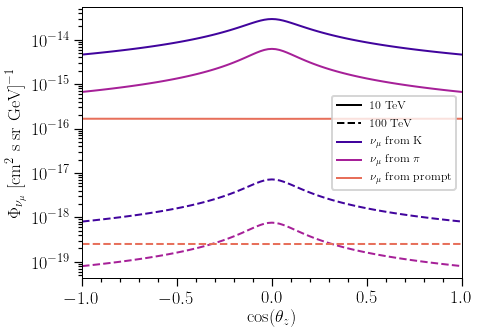

In [66]:
closest_MCEq_energy_idx = lambda e: np.argmin(np.abs(e-mceq_run.e_grid))
e_grid = mceq_run.e_grid

idx0 = closest_MCEq_energy_idx(1e4) + 1# 10 TeV
idx1 = closest_MCEq_energy_idx(1e5) + 1 # 100 TeV

cm = plt.get_cmap('plasma')
colors = [cm((i/3*0.8)+0.1) for i in range(3)]

cos_theta_eff_grid = geometry.cos_theta_eff(cos_theta_grid)
linestyles = ['-', '--']
flavor_labels = [r'$\nu_\mu$', r'$\nu_e$']

fig, ax = plt.subplots(sharey=True, figsize=(7,5))
artists = []
labels = []
artists.append(matplotlib.lines.Line2D([0],[0], color='black', linestyle='-'))
artists.append(matplotlib.lines.Line2D([0],[0], color='black', linestyle='--'))
labels.append(r'$10~\textrm{TeV}$')
labels.append(r'$100~\textrm{TeV}$')
for i, idx in enumerate([idx0, idx1]):
    add_label = i == 0
    if add_label:
        labels.append(flavor_labels[i] + r' from K')
        labels.append(flavor_labels[i] + r' from $\pi$')
        labels.append(flavor_labels[i] + r' from prompt')
        artists.append(matplotlib.lines.Line2D([0],[0], color=colors[0], linestyle='-'))
        artists.append(matplotlib.lines.Line2D([0],[0], color=colors[1], linestyle='-'))
        artists.append(matplotlib.lines.Line2D([0],[0], color=colors[2], linestyle='-'))
    a = ax.plot(cos_theta_grid,
            np.array(flux['numu_k'])[:,idx]/e_grid[idx]**mag,
            color=colors[0], linestyle=linestyles[i])
    artists.append(a)
    a = ax.plot(cos_theta_grid,
            np.array(flux['numu_pi'])[:,idx]/e_grid[idx]**mag,
            color=colors[1], linestyle=linestyles[i])
    artists.append(a)
    a = ax.plot(cos_theta_grid,
            np.array(flux['numu_pr'])[:,idx]/e_grid[idx]**mag,
            color=colors[2], linestyle=linestyles[i])
    artists.append(a)

ax.set_ylabel(r"$\Phi_{\nu_\mu}$ [cm$^{2}$ s sr GeV]$^{-1}$")
ax.set_ylabel(r"$\Phi_{\nu_\mu}$ [cm$^{2}$ s sr GeV]$^{-1}$")
ax.set_xlabel(r'$\cos(\theta_z)$')
ax.set_xlabel(r'$\cos(\theta_z)$')
ax.set_yscale('log')
ax.set_xlim((-1,1))
ax.legend(artists, labels, frameon=True)
fig.tight_layout()
fig.savefig('atm_flux.pdf')

In [20]:
print(cos_theta_eff_grid)

[1.         0.98001233 0.96002491 0.94003778 0.92005093 0.9000644
 0.88007821 0.86009237 0.84010691 0.82012187 0.80013727 0.78015315
 0.76016954 0.74018648 0.72020403 0.70022223 0.68024114 0.66026083
 0.64028137 0.62030283 0.60032532 0.58034894 0.5603738  0.54040006
 0.52042786 0.5004574  0.48048888 0.46052257 0.44055876 0.4205978
 0.40064013 0.38068627 0.36073684 0.34079262 0.32085458 0.30092396
 0.28100232 0.26109174 0.24119493 0.22131563 0.20145901 0.18163252
 0.16184721 0.14212031 0.12248001 0.10297591 0.08370326 0.06486866
 0.04700174 0.03177886 0.02470101 0.03177886 0.04700174 0.06486866
 0.08370326 0.10297591 0.12248001 0.14212031 0.16184721 0.18163252
 0.20145901 0.22131563 0.24119493 0.26109174 0.28100232 0.30092396
 0.32085458 0.34079262 0.36073684 0.38068627 0.40064013 0.4205978
 0.44055876 0.46052257 0.48048888 0.5004574  0.52042786 0.54040006
 0.5603738  0.58034894 0.60032532 0.62030283 0.64028137 0.66026083
 0.68024114 0.70022223 0.72020403 0.74018648 0.76016954 0.7801531

In [4]:
depths = [1500., 1950., 2300.]
overburdens = []
cos_theta_effs = []
for depth in depths:
    geometry = Geometry(depth*Units.m)
    overburdens.extend(geometry.overburden(cos_theta_grid))
    cos_theta_effs.extend(geometry.cos_theta_eff(cos_theta_grid))
overburdens = np.sort(np.unique(overburdens))
cos_theta_effs = np.sort(np.unique(cos_theta_effs))
for o in overburdens:
    print(o*100)

150000.00000000547
151514.79049690592
153060.48386806514
154638.03540282423
156248.44016949818
157892.73510746847
159572.0012524404
161287.36610513166
163040.00615509236
164831.14956977943
166662.07906324227
168534.13495748502
170448.71845351922
172407.29512646384
174411.39866457845
176462.6348729031
178562.68596088886
180713.3151411531
182916.37156333774
185173.79561314805
187487.62460930806
189859.998931023
192293.16861729894
194789.5004796119
195000.00000002148
196969.08684974944
197351.48577537824
198978.34018954769
199981.74849391283
201029.00148874192
202683.05431366884
203122.3639023177
205259.77498899665
205458.32029493627
207442.63960203243
208310.6253786389
209672.4229661511
211243.22177040967
211950.65395535156
214259.54730010967
214278.92858649825
216658.91374485794
217363.23885356
219092.35116160972
220558.1469872537
221581.0616612022
223848.3518498806
224126.9497015312
226732.00823098532
227238.18054864017
229398.3238868393
230000.00000004188
230732.2261159048
232128.0825

In [ ]:
cos_theta_grid = np.linspace(0,1,5+1)
f = open('./surface_mu_fluxes.txt', 'w')
for cos_theta_eff in cos_theta_effs:
    theta_eff_deg = np.arccos(cos_theta_eff)*180./np.pi
    mceq_run = MCEqRun(
        'SIBYLL-2.3c',
        primary_model=(pm.HillasGaisser2012, 'H3a'),
        theta_deg=theta_eff_deg,
        density_model=('CORSIKA', ('SouthPole', 'December')),
    )
    X_vec = np.logspace(np.log10(2e-3),
                            np.log10(mceq_run.density_model.max_X), 12)
    X_vec = 10**(lambda x: (x[:-1]+x[1:])/2.)(np.log10(X_vec))
    mceq_run.solve(int_grid=X_vec, grid_var="X")
    surface_mu_flux = (mceq_run.get_solution("total_mu+", 0) + mceq_run.get_solution("total_mu-", 0))
    f.write(str(cos_theta_eff) + ' ' + ' '.join([str(f) for f in surface_mu_flux]) + '\n')
    del mceq_run
    del surface_mu_flux
f.close()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('SouthPole', 'December')
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('SouthPole', 'December')
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('SouthPole', 'December')
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::se

In [11]:
X_vec = np.logspace(np.log10(2e-3),
                            np.log10(mceq_run.density_model.max_X), 12)
X_vec = 10**(lambda x: (x[:-1]+x[1:])/2.)(np.log10(X_vec))

In [13]:
mceq_run.solve(int_grid=X_vec, grid_var="X")

In [22]:
surface_mu_flux = (mceq_run.get_solution("total_mu+", 0, grid_idx=i) + mceq_run.get_solution("total_mu-", 0, grid_idx=i))

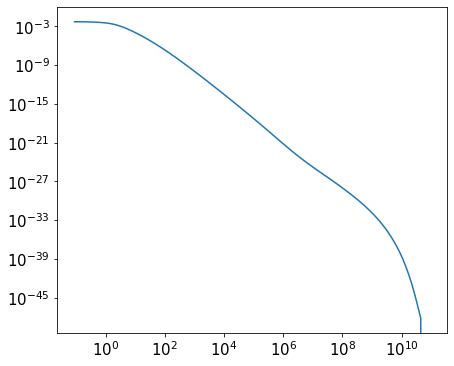

In [53]:
fig, ax = plt.subplots()
ax.plot(mceq_run.e_grid, surface_mu_flux)
ax.set_xscale('log')
ax.set_yscale('log')

In [76]:
energy = (lambda x: (x[:-1]+x[1:])/2.)(10.**(11+np.arange(-121,1)*0.1)) # in GeV
distance = overburdens # in m
energy_bins = 10.**(11+np.arange(-121,1)*0.1) # in GeV

In [ ]:
f = open('../PROPOSALsrc/build/bin/output.txt', 'r')
entries = np.zeros((len(energy), len(distance), 0)).tolist()
initial_energies = []
distances = []
final_energies = []
for line in f:
    items = line.split(' ')
    energy_i = int(items[0])
    distance_i = int(items[1])
    final_energy = float(items[2])/1e3
    if distance_i == len(distance):
        continue
    if energy_i == len(energy):
        continue
    entries[energy_i][distance_i].append(final_energy)
    initial_energies.append(energy[energy_i])
    distances.append(distance[distance_i])
    final_energies.append(final_energy)
initial_energies = np.array(initial_energies)
distances = np.array(distances)
final_energies = np.array(final_energies)
entries = np.array(entries)